In this notebook we will use a <a href="https://scikit-learn.org/stable/" target="_blank" rel="noopener">`scikit-learn`</a> model created earlier to classify the radiation source of Cherenkov shower images. You can find more information about the problem domain <a href="https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope" target="_blank" rel="noopener">here</a>.

We will be using a generic prediction UDF script. To execute queries and load data from Exasol database we will be using the <a href="https://github.com/exasol/pyexasol" target="_blank" rel="noopener">`pyexasol`</a> module.

Prior to running this notebook one needs to complete the follow steps:
1. [Create generic scikit-learn prediction UDF script](sklearn_predict_udf.ipynb).
2. [Train a model on the MAGIC Gamma Telescope data](sklearn_train_telescope.ipynb).

In [1]:
# TODO: Move this to a separate configuration notebook. Here we just need to load this configuration from a store.
from dataclasses import dataclass

@dataclass
class SandboxConfig:
    EXTERNAL_HOST_NAME = "192.168.124.93"
    HOST_PORT = "8888"

    @property
    def EXTERNAL_HOST(self):
        return f"""{self.EXTERNAL_HOST_NAME}:{self.HOST_PORT}"""

    USER = "sys"
    PASSWORD = "exasol"
    BUCKETFS_PORT = "6666"
    BUCKETFS_USER = "w"
    BUCKETFS_PASSWORD = "write"
    BUCKETFS_USE_HTTPS = False
    BUCKETFS_SERVICE = "bfsdefault"
    BUCKETFS_BUCKET = "default"

    @property
    def EXTERNAL_BUCKETFS_HOST(self):
        return f"""{self.EXTERNAL_HOST_NAME}:{self.BUCKETFS_PORT}"""

    @property
    def BUCKETFS_URL_PREFIX(self):
        return "https://" if self.BUCKETFS_USE_HTTPS else "http://"

    @property
    def BUCKETFS_PATH(self):
        # Filesystem-Path to the read-only mounted BucketFS inside the running UDF Container
        return f"/buckets/{self.BUCKETFS_SERVICE}/{self.BUCKETFS_BUCKET}"

    SCRIPT_LANGUAGE_NAME = "PYTHON3_60"
    UDF_FLAVOR = "python3-ds-EXASOL-6.0.0"
    UDF_RELEASE= "20190116"
    UDF_CLIENT = "exaudfclient" # or for newer versions of the flavor exaudfclient_py3
    SCHEMA = "IDA"

    @property
    def SCRIPT_LANGUAGES(self):
        return f"""{self.SCRIPT_LANGUAGE_NAME}=localzmq+protobuf:///{self.BUCKETFS_SERVICE}/
            {self.BUCKETFS_BUCKET}/{self.UDF_FLAVOR}?lang=python#buckets/{self.BUCKETFS_SERVICE}/
            {self.BUCKETFS_BUCKET}/{self.UDF_FLAVOR}/exaudf/{self.UDF_CLIENT}""";

    @property
    def connection_params(self):
        return {"dns": self.EXTERNAL_HOST, "user": self.USER, "password": self.PASSWORD, "compression": True}

    @property
    def params(self):
        return {
            "script_languages": self.SCRIPT_LANGUAGES,
            "script_language_name": self.SCRIPT_LANGUAGE_NAME,
            "schema": self.SCHEMA,
            "BUCKETFS_PORT": self.BUCKETFS_PORT,
            "BUCKETFS_USER": self.BUCKETFS_USER,
            "BUCKETFS_PASSWORD": self.BUCKETFS_PASSWORD,
            "BUCKETFS_USE_HTTPS": self.BUCKETFS_USE_HTTPS,
            "BUCKETFS_BUCKET": self.BUCKETFS_BUCKET,
            "BUCKETFS_PATH": self.BUCKETFS_PATH
        }

conf = SandboxConfig()

Let's classify the data we have in the TELESCOPE_TEST table. This table also includes a column with ground truth labels. We will use it to access the performance of our classifier. In the code below we will add the ROWID to the output columns (as required by the generic prediction UDF). This will allow us to link the result to the ground truth.

In [2]:
import pyexasol
from stopwatch import Stopwatch

LABEL_COLUMN = 'CLASS'
params = dict(conf.params)
params['test_table'] = 'TELESCOPE_TEST'
params['model_path'] = f'{conf.BUCKETFS_PATH}/telescope_tree_model.pkl'

stopwatch = Stopwatch()

with pyexasol.connect(dsn=conf.EXTERNAL_HOST, user=conf.USER, password=conf.PASSWORD, compression=True) as conn:
    # Get the list of feature columns
    sql = 'SELECT * FROM {schema!i}.{test_table!i} LIMIT 1'
    df_tmp = conn.export_to_pandas(query_or_table=sql, query_params=params)
    params['column_names'] = [f'[{c}]' for c in df_tmp.columns if c != LABEL_COLUMN]

    # Get the predictions for all rows in the TEST table calling the prediction UDF.
    # Provide the model path and the row id int the first two parameters.
    sql = f'SELECT {{schema!i}}.SKLEARN_PREDICT({{model_path!s}}, ROWID, {{column_names!r}}) ' \
        f'emits ([sample_id] DECIMAL(20,0), [{LABEL_COLUMN}] CHAR(1)) FROM {{schema!i}}.{{test_table!i}}'
    df_pred = conn.export_to_pandas(query_or_table=sql, query_params=params)

print(f"Getting predictions took: {stopwatch}")
df_pred.head()

Getting predictions took: 3.01s


,sample_id,CLASS
0,18446744073709555295,h
1,18446744073709555324,g
2,18446744073709555049,h
3,18446744073709554419,g
4,18446744073709551751,g


We are going to check the performance of our classifier by linking the results to the ground truth labels and computing the confusion matrix. This should give us similar results to what we have seen in the [training notebook](sklearn_train_telescope.ipynb).

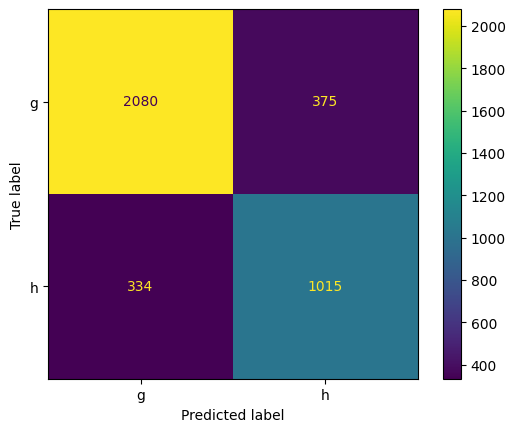

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get the ground truth labels for the test set.
with pyexasol.connect(dsn=conf.EXTERNAL_HOST, user=conf.USER, password=conf.PASSWORD, compression=True) as conn:
    sql = f'SELECT ROWID AS [sample_id], [{LABEL_COLUMN}] FROM {{schema!i}}.{{test_table!i}}'
    df_true = conn.export_to_pandas(query_or_table=sql, query_params=params)

# Merge predictions and the ground truth on the sample id.
df_res = pd.merge(left=df_true, right=df_pred, on='sample_id', suffixes=['_true', '_pred'])

# Get the label names
labels=df_res[f'{LABEL_COLUMN}_true'].unique()

# Build and display the confusion matrix.
cm = confusion_matrix(df_res[f'{LABEL_COLUMN}_true'], df_res[f'{LABEL_COLUMN}_pred'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()